In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
import psycopg2
import psycopg2.extras

import matplotlib.pyplot as plt

import io
import datetime
import joblib
import json
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



In [2]:
PATH = '/content/drive/MyDrive/Colab Notebooks/hack30112024/'

SERIES_LENGTH = 64

In [3]:
files = []

for file_it in range(1, 6):
    f = pd.read_csv(PATH + 'input/data' + str(file_it) + '.csv')['value'].to_numpy().astype(np.float32).reshape(-1, 1)
    f = np.nan_to_num(f)

    files += [f]

In [44]:
# joblib.dump(scaler, PATH + '/scaler.gz')

['/content/drive/MyDrive/Colab Notebooks/hack30112024//scaler.gz']

In [4]:
prep_rows = np.concatenate(files)
scaler = MinMaxScaler().fit(prep_rows)
sc_rows = scaler.transform(prep_rows)

In [5]:
prep_rows.max(), prep_rows.min(), sc_rows.max(), sc_rows.min()

(7713.0, 0.0, 1.0, 0.0)

In [6]:

def transform(rows):
    X, y = [], []

    rows = scaler.transform(rows)

    for it in range(SERIES_LENGTH, len(rows)):

        X.append(rows[it - SERIES_LENGTH : it])
        y.append(rows[it])

    return X, y


X_train, X_test, y_train, y_test = [], [], [], []
files_data = []

for file in files:

    rows = file[:, 0 : 1]

    X_, y_ = transform(rows)

    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.10, random_state=42, shuffle=False)

    X_train += X_train_
    X_test += X_test_
    y_train += y_train_
    y_test += y_test_

    files_data += [{'X_train': X_train_, 'X_test': X_test_, 'y_train': y_train_, 'y_test': y_test_}]



X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3518, 64, 1), (3518, 1), (392, 64, 1), (392, 1))

In [10]:

inputs = keras.layers.Input(shape=X_train.shape[1:])

hide = keras.layers.LSTM(64, return_sequences=True)(inputs)
hide = keras.layers.LSTM(64, return_sequences=False)(hide)

outputs = keras.layers.Dense(y_train.shape[-1], activation=keras.activations.sigmoid)(hide)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

def metric_abs(y_true, y_pred):
    return tf.math.abs(1.0 - y_true / y_pred)



model.compile(optimizer=keras.optimizers.Adam(0.01), loss=metric_abs, metrics=[keras.losses.mean_absolute_error])

es_callback = keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True
)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=PATH + "checkpoint/model_3.weights.h5",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

try:
    model.load_weights(modelckpt_callback.filepath)
except:
    pass

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[es_callback, modelckpt_callback],
    batch_size=30
)

Epoch 1/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0658 - mean_absolute_error: 0.0065
Epoch 1: loss did not improve from 0.05071
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0658 - mean_absolute_error: 0.0065 - val_loss: 0.1556 - val_mean_absolute_error: 0.0149
Epoch 2/1000
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0615 - mean_absolute_error: 0.0061
Epoch 2: loss did not improve from 0.05071
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0615 - mean_absolute_error: 0.0061 - val_loss: 0.1569 - val_mean_absolute_error: 0.0150
Epoch 3/1000
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0617 - mean_absolute_error: 0.0056
Epoch 3: loss did not improve from 0.05071
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0617 - mean_absolute_error: 0.0056 - val_loss: 0.1568 - val_mean_absolute_error: 0.0143
Epoch 4/1000
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0633 - mean_absolute_error: 0.0057
Epoch 4: loss did not improve from 0.05071
118/118 

In [12]:
loss = history.history["loss"][::2]
metric_abs = history.history["mean_absolute_error"][::2]

epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="loss")
plt.plot(epochs, metric_abs, "g", label="mean_absolute_error")
plt.title("Потери")
plt.xlabel("Эпохи")
plt.ylabel("Функция потерь")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [18]:
model.load_weights(modelckpt_callback.filepath)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
def predict_next(rows, count):
    X = scaler.transform(rows[ - SERIES_LENGTH :])
    result = []

    for it in range(count):

        new_row = model.predict(X.reshape(1, -1, 1), verbose=0)[0]

        result.append(new_row)

        X = np.concatenate([X[1 :], [new_row]])

    if len(result) != 0:
        result = scaler.inverse_transform(result)

    return np.array(result)


In [15]:
model.evaluate(X_train, y_train)

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0372 - mean_absolute_error: 0.0060


[0.048614490777254105, 0.004394510295242071]

In [16]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1510 - mean_absolute_error: 0.0202


[0.16473594307899475, 0.015080917626619339]

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


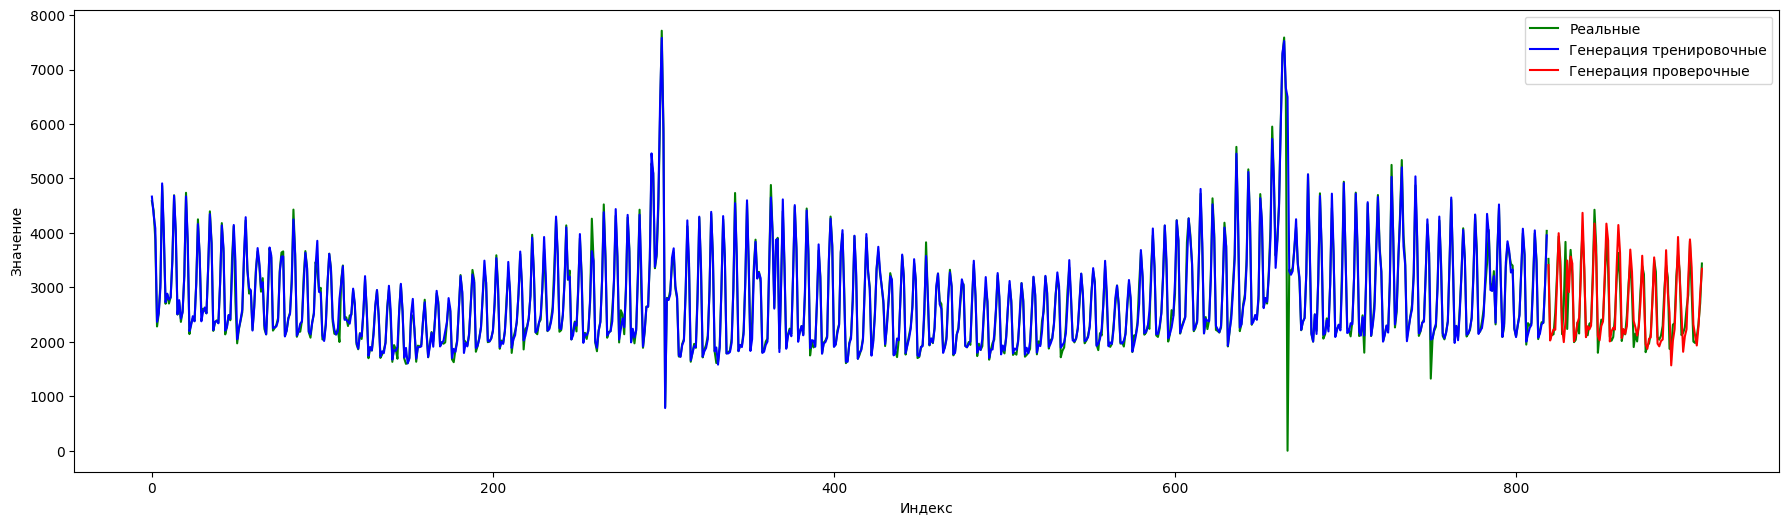

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


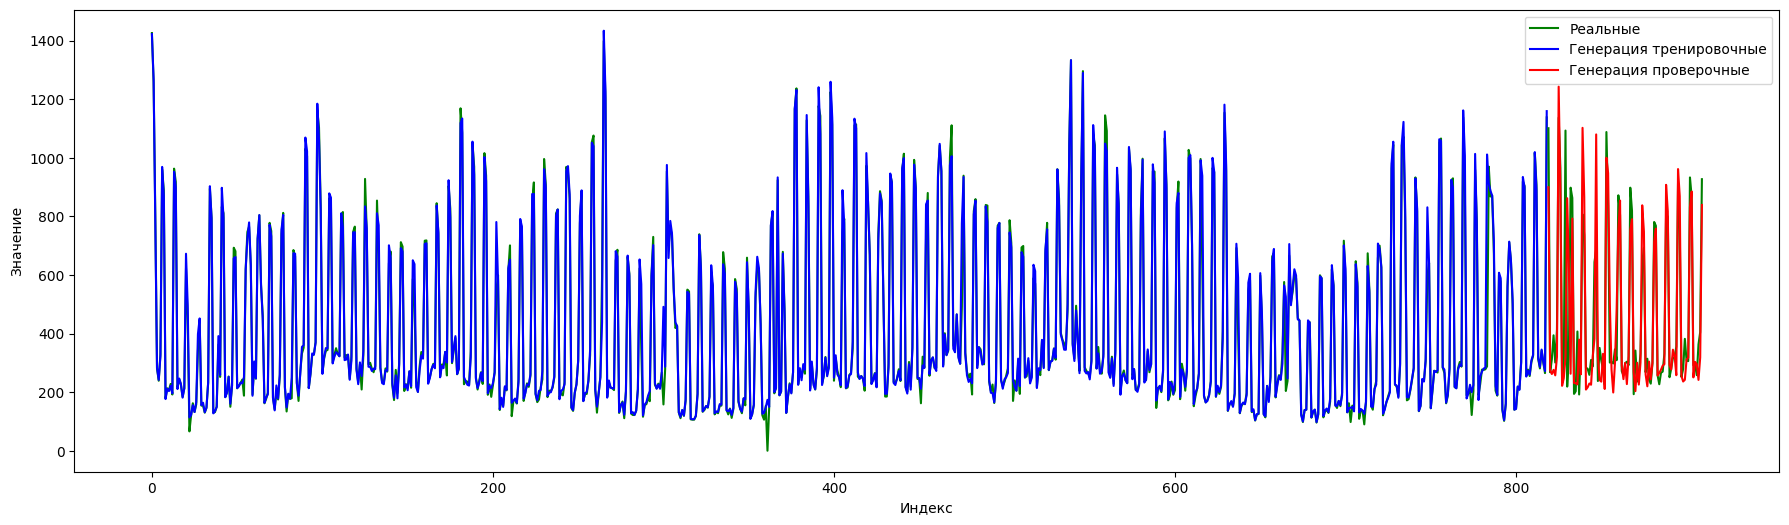

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


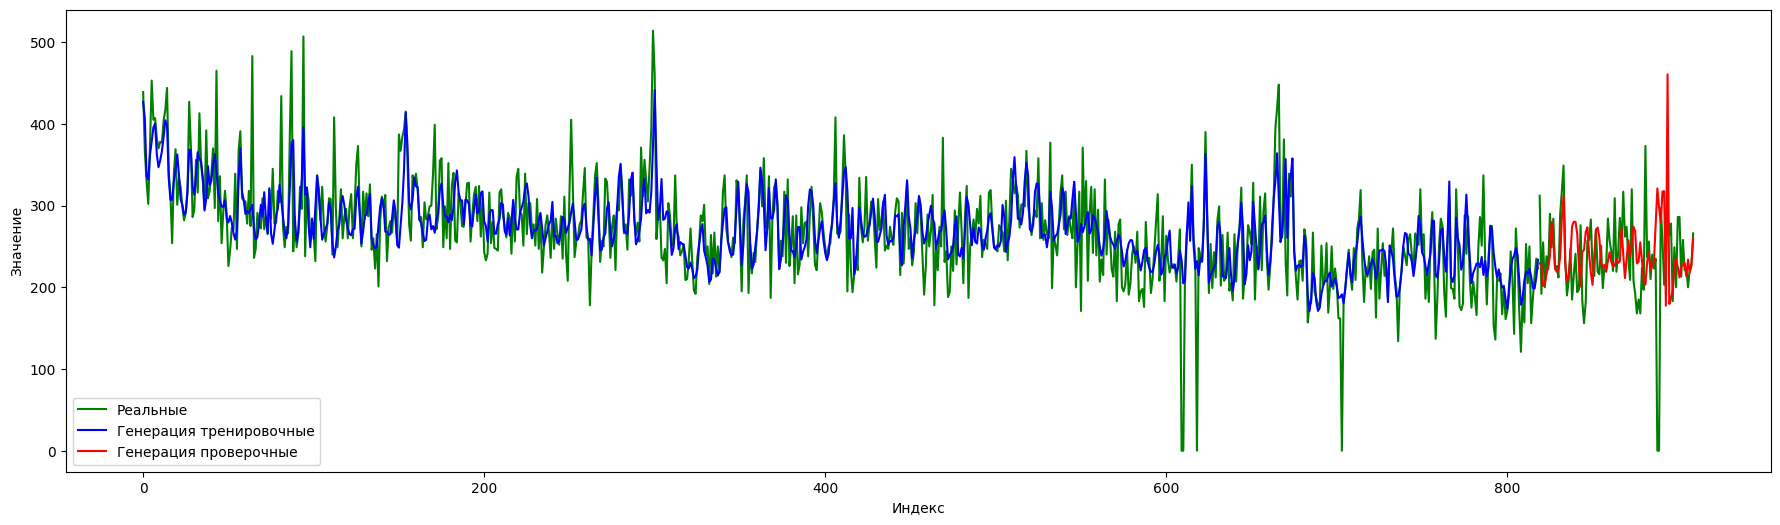

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


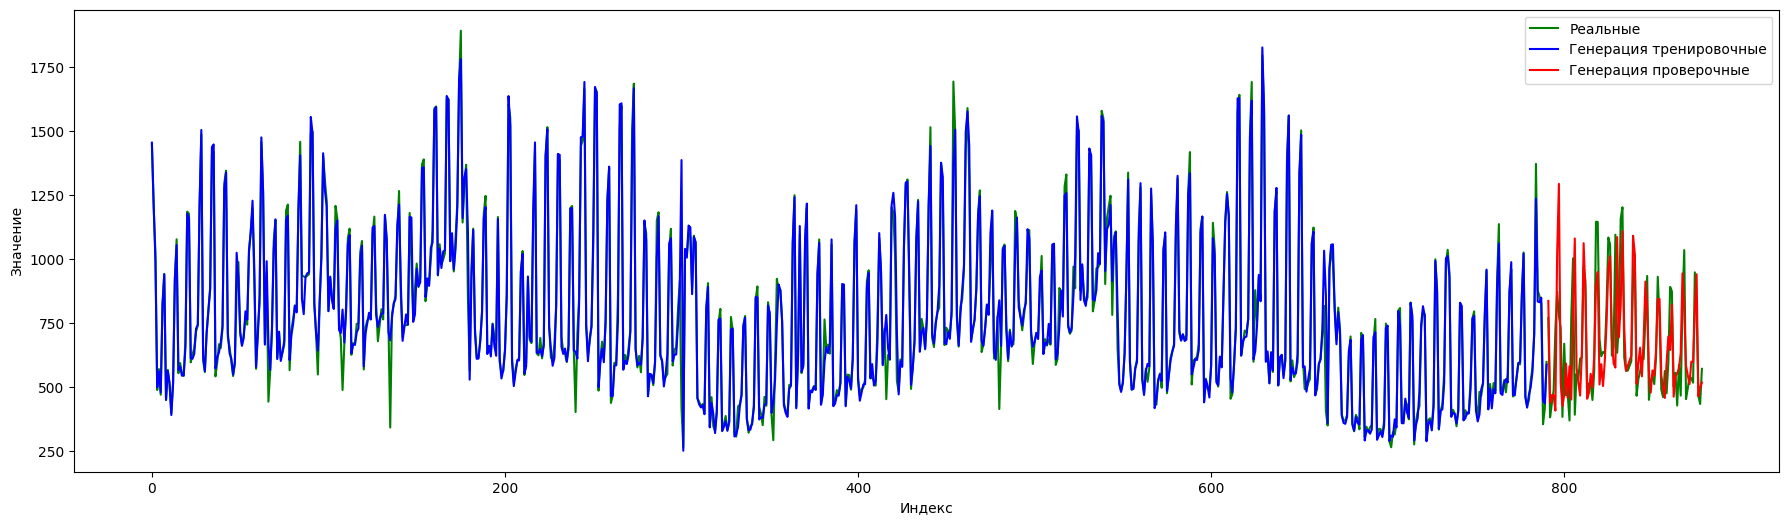

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


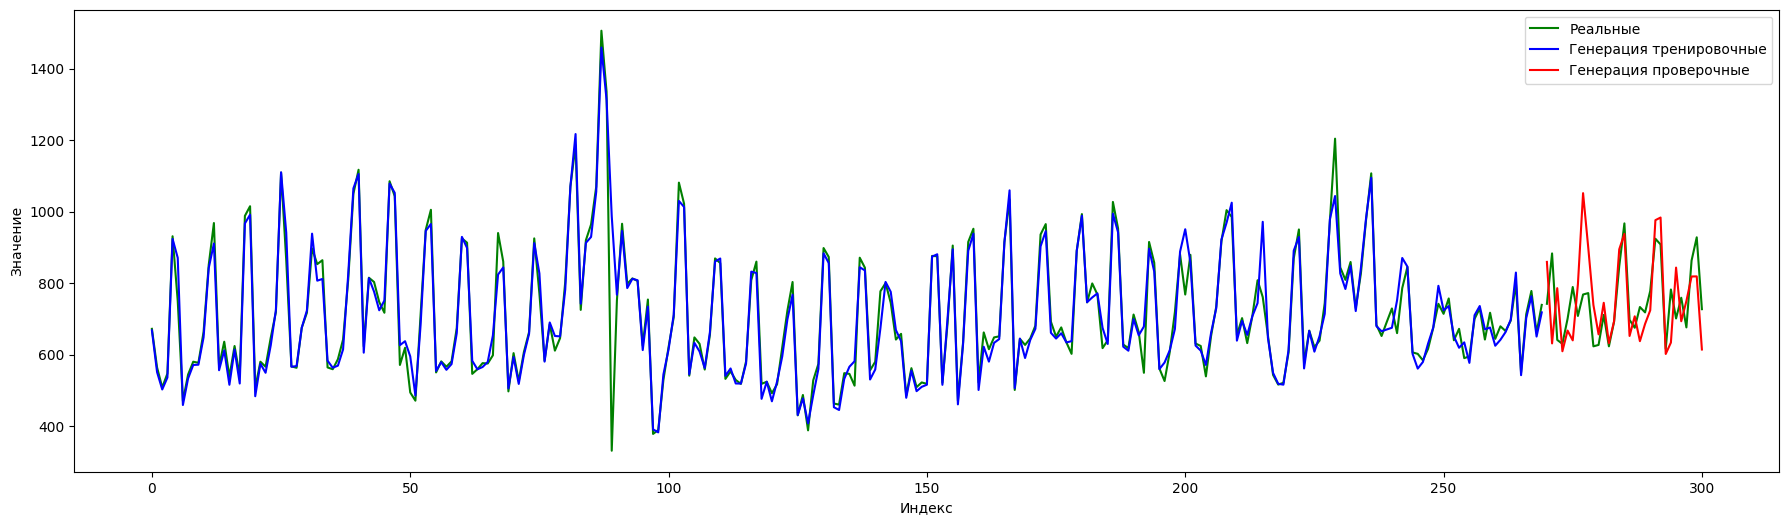

In [17]:
for file in files_data:

    X_train_ = file['X_train']
    y_train_ = scaler.inverse_transform(file['y_train'])
    y_train_pred_ = scaler.inverse_transform(model.predict(np.array(X_train_)))

    X_test_ = file['X_test']
    y_test_ = scaler.inverse_transform(file['y_test'])
    y_test_pred_ = scaler.inverse_transform(model.predict(np.array(X_test_)))

    plt.figure(figsize=(22, 6))
    plt.plot(range(len(y_train_)), y_train_[:, 0], color='green', label='Реальные')
    plt.plot(range(len(y_train_pred_)), y_train_pred_[:, 0], color='blue', label='Генерация тренировочные')

    plt.plot(range(len(y_train_), len(y_train_) + len(y_test_)), y_test_[:, 0], color='green')
    plt.plot(range(len(y_train_pred_), len(y_train_pred_) + len(y_test_pred_)), y_test_pred_[:, 0], color='red', label='Генерация проверочные')


    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0336 - mean_absolute_error: 0.0032
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


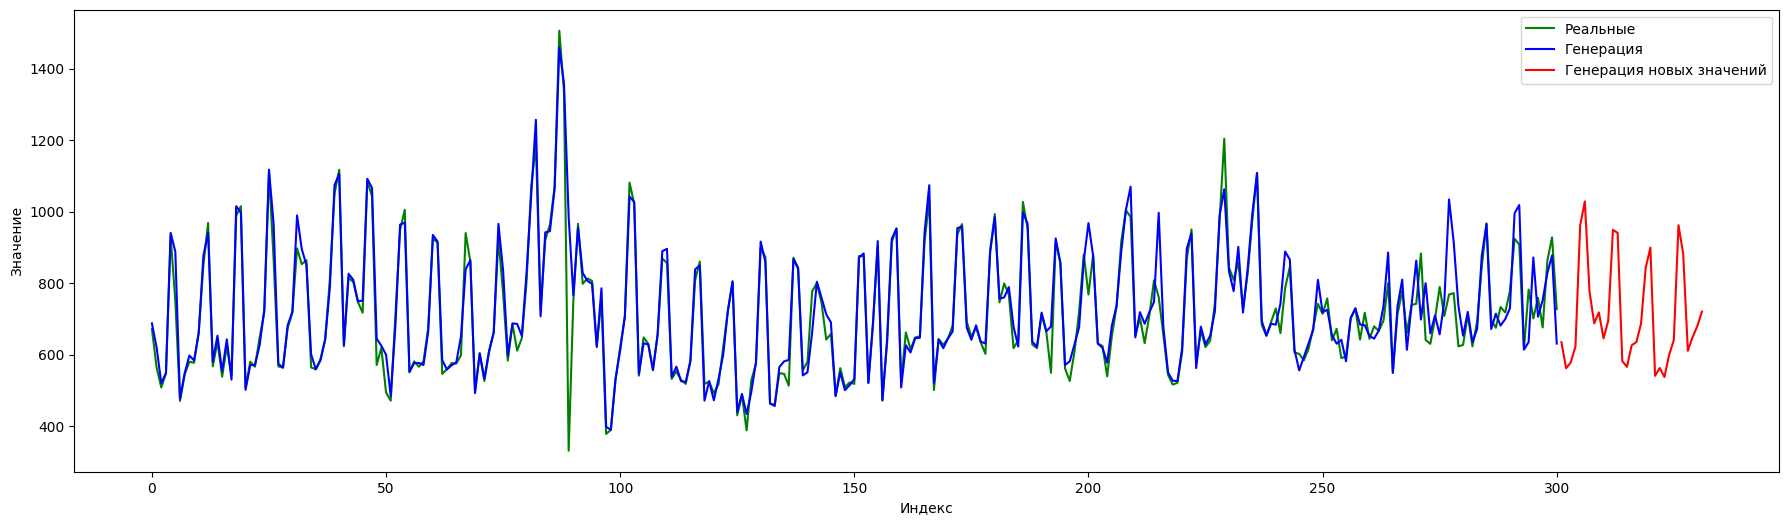

In [40]:
file = files[4]

X, y = transform(file)

X = np.array(X)
y = np.array(y)

model.load_weights(modelckpt_callback.filepath)

model.fit(
    X, y,
    epochs=1,
    shuffle=True,
    callbacks=[es_callback],
    batch_size=30
)


y = scaler.inverse_transform(y)
y_train_pred = scaler.inverse_transform(model.predict(np.array(X)))

y_new = predict_next(file, 31)


plt.figure(figsize=(22, 6))
plt.plot(range(len(y)), y[:, 0], color='green', label='Реальные')
plt.plot(range(len(y_train_pred)), y_train_pred[:, 0], color='blue', label='Генерация')

plt.plot(range(len(y_train_pred), len(y_train_pred) + len(y_new)), y_new[:, 0], color='red', label='Генерация новых значений')


plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [45]:
file.astype(np.int32).reshape(-1)

array([ 713,  788,  785,  850,  904, 1177, 1280,  813,  957,  907,  971,
       1010, 1443, 1375,  907,  972,  984, 1038, 1130, 1395, 1360,  832,
       1000,  867, 1060, 1060, 1187, 1377, 1011, 1390, 1223,  973,  937,
        928, 1444,  919, 1024,  854,  801,  739, 1049, 1192,  689,  778,
        724,  724,  744,  927,  909,  651,  519,  535,  541,  628,  663,
        839,  757,  702,  700,  630,  673, 1006,  955,  564,  672,  564,
        508,  547,  931,  750,  470,  544,  580,  577,  663,  851,  968,
        567,  636,  538,  624,  541,  988, 1015,  507,  580,  566,  647,
        719, 1109,  864,  567,  563,  675,  717,  897,  853,  864,  564,
        559,  587,  642,  810, 1050, 1117,  623,  815,  803,  747,  717,
       1085, 1043,  571,  619,  494,  471,  709,  949, 1005,  550,  581,
        566,  581,  674,  925,  913,  546,  559,  576,  575,  598,  940,
        860,  497,  604,  526,  607,  663,  925,  771,  583,  685,  611,
        646,  803, 1070, 1186,  725,  920,  964, 10